In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.compose import ColumnTransformer
import warnings

In [36]:
df = pd.read_csv('data/StudentsPerformance.csv')

In [11]:
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [12]:
df.shape

(1000, 8)

In [13]:
df.isnull().sum()

gender                         0
race/ethnicity                 0
parental level of education    0
lunch                          0
test preparation course        0
math score                     0
reading score                  0
writing score                  0
dtype: int64

In [15]:
df.duplicated().sum()

np.int64(0)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


In [19]:
df.nunique()

gender                          2
race/ethnicity                  5
parental level of education     6
lunch                           2
test preparation course         2
math score                     81
reading score                  72
writing score                  77
dtype: int64

In [21]:
df.describe()

,math score,reading score,writing score
count,1000.00000,1000.000000,1000.000000
mean,66.08900,69.169000,68.054000
std,15.16308,14.600192,15.195657
min,0.00000,17.000000,10.000000
25%,57.00000,59.000000,57.750000
50%,66.00000,70.000000,69.000000
75%,77.00000,79.000000,79.000000
max,100.00000,100.000000,100.000000


In [23]:
num_features = [features for features in df.columns if df[features].dtype != 'O']
cat_features = [features for features in df.columns if df[features].dtype == 'O']
print(len(cat_features))
print(len(num_features))

5
3


In [24]:
df.head(2)

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88


In [46]:
df['total_score']= df['math score']+df['reading score']+df['writing score']
df['average'] = df['total_score']/3
df.head(3)

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,total_score,average
0,female,group B,bachelor's degree,standard,none,72,72,74,218,72.666667
1,female,group C,some college,standard,completed,69,90,88,247,82.333333
2,female,group B,master's degree,standard,none,90,95,93,278,92.666667


In [47]:
reading_full = df[df['reading score'] == 100]['average'].count()
writing_full = df[df['writing score'] == 100]['average'].count()
math_full = df[df['math score'] == 100]['average'].count()

print(f'no of students got full marks in maths ',math_full)
print(f'no of students got full marks in reading ',reading_full)
print(f'no of students got full marks in writing ',writing_full)

no of students got full marks in maths  7
no of students got full marks in reading  17
no of students got full marks in writing  14


In [48]:
reading_les = df[df['reading score'] <= 20]['average'].count()
writing_les = df[df['writing score'] <= 20]['average'].count()
math_les = df[df['math score'] <= 20]['average'].count()

print(f'no of students got les marks in maths ',math_les)
print(f'no of students got les marks in reading ',reading_les)
print(f'no of students got les marks in writing ',writing_les)

no of students got les marks in maths  4
no of students got les marks in reading  1
no of students got les marks in writing  3


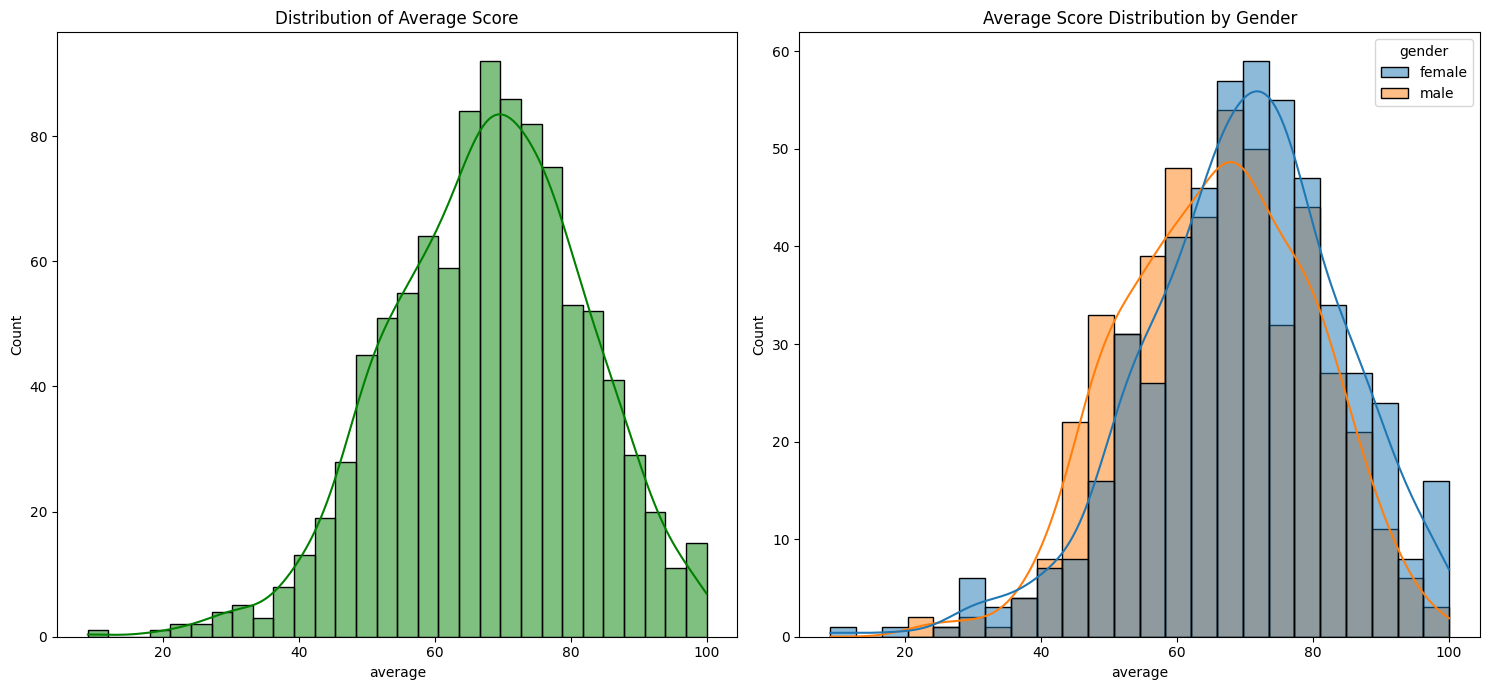

In [51]:

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(15, 7))

# First plot
sns.histplot(data=df, x='average', bins=30, kde=True, color='g', ax=axs[0])
axs[0].set_title('Distribution of Average Score')

# Second plot
sns.histplot(data=df, x='average', kde=True, hue='gender', ax=axs[1])
axs[1].set_title('Average Score Distribution by Gender')

plt.tight_layout()
plt.show()


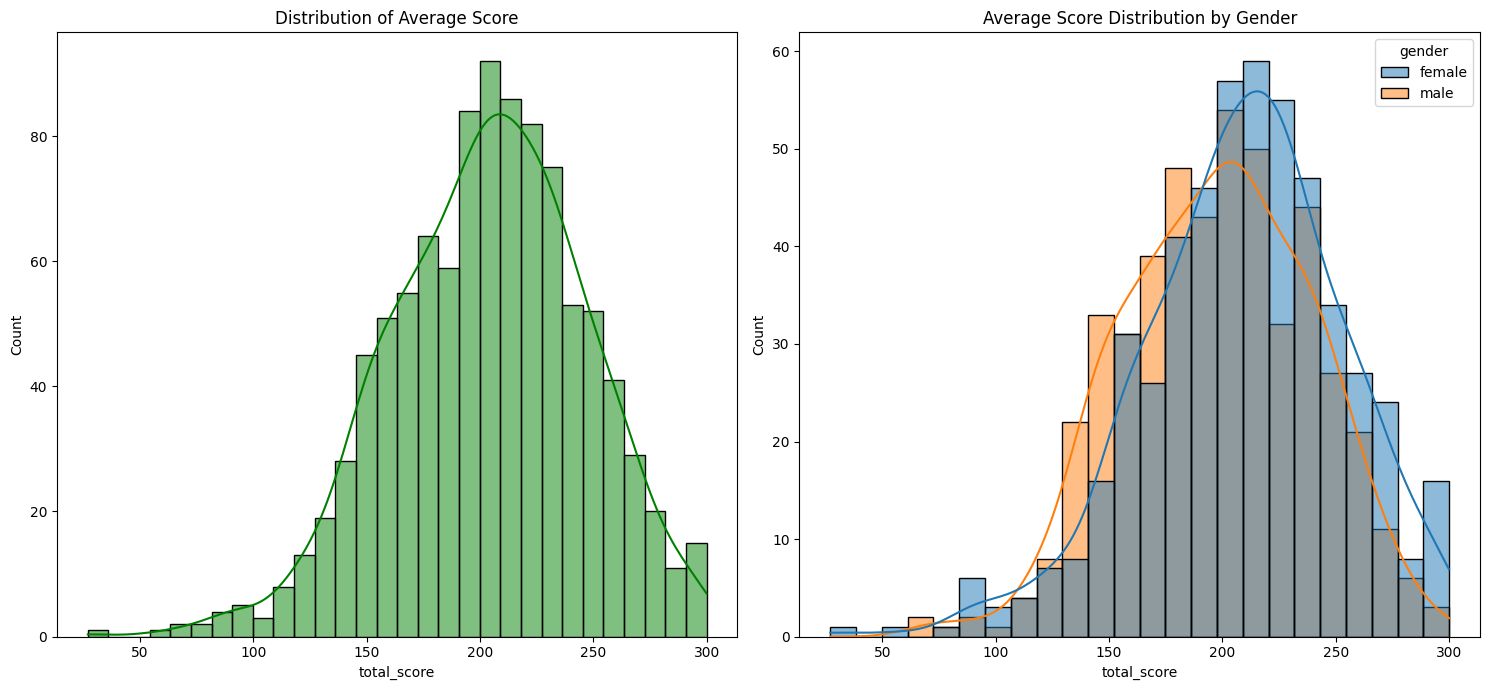

In [53]:

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(15, 7))

# First plot
sns.histplot(data=df, x='total_score', bins=30, kde=True, color='g', ax=axs[0])
axs[0].set_title('Distribution of Average Score')

# Second plot
sns.histplot(data=df, x='total_score', kde=True, hue='gender', ax=axs[1])
axs[1].set_title('Average Score Distribution by Gender')

plt.tight_layout()
plt.show()


In [59]:
x = df.drop(columns=['math score'],axis=1)

In [60]:
y = df['math score']

In [65]:
num_features = x.select_dtypes(exclude='object').columns
cat_features = x.select_dtypes(include='object').columns

sc= StandardScaler()
ob = OneHotEncoder()

preprocess = ColumnTransformer(
[
    ('OneHotEncoder',ob,cat_features),
    ('StandardScaler',sc,num_features)
]

)





In [66]:
x = preprocess.fit_transform(x)

In [67]:
x.shape

(1000, 21)

In [72]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)
x_train.shape,x_test.shape

((800, 21), (200, 21))

In [75]:
def evaluate_model(true,predicted):
    mae = mean_absolute_error(true,predicted)
    mse = mean_squared_error(true,predicted)
    rmse = np.sqrt(mean_squared_error(true,predicted))
    r2_score = r2_score(true,predicted)
    return mae,mse,rmse,r2_score


In [93]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return mae, rmse, r2

models = {
    "LinearRegression" : LinearRegression(),
    "Lasso" : Lasso(),
    "AdaBoostRegressor" : AdaBoostRegressor(),
    "DecisionTreeRegressor" : DecisionTreeRegressor(),
    "XGBRegressor":XGBRegressor(),
    "Ridge" : Ridge(),
    "CatBoostRegressor":CatBoostRegressor(),
    "knn" : KNeighborsRegressor()
}

model_list = []
r2_list = []

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(x_train,y_train)
     
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)

    model_train_mae, model_train_rmse,model_train_r2 = evaluate_model(y_train,y_train_pred)
    model_test_mae, model_test_rmse,model_test_r2 = evaluate_model(y_test,y_test_pred)

    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])

    print('model performance for taining set')
    print("rmse:", '{:,.4f}'.format(model_test_rmse))  # ✅ Correct
    print("mae:",'{:,.4f}'.format(model_train_mae))
    print("r2_score:",'{:,.4f}'.format(model_train_r2))
    r2_list.append(model_train_r2)

    print("rmse:",'{:,.4f}'.format(model_test_rmse))
    print("mae:",'{:,.4f}'.format(model_test_mae))
    print("r2_score:",'{:,.4f}'.format(model_test_r2))
    r2_list.append(model_test_r2)

    print('='*35)
    print('\n')


LinearRegression
model performance for taining set
rmse: 0.0000
mae: 0.0000
r2_score: 1.0000
rmse: 0.0000
mae: 0.0000
r2_score: 1.0000


Lasso
model performance for taining set
rmse: 4.7171
mae: 3.7439
r2_score: 0.9004
rmse: 4.7171
mae: 3.7579
r2_score: 0.9086


AdaBoostRegressor
model performance for taining set
rmse: 4.2017
mae: 3.1864
r2_score: 0.9320
rmse: 4.2017
mae: 3.3086
r2_score: 0.9274


DecisionTreeRegressor
model performance for taining set
rmse: 3.7868
mae: 0.0000
r2_score: 1.0000
rmse: 3.7868
mae: 3.0100
r2_score: 0.9411


XGBRegressor
model performance for taining set
rmse: 2.3605
mae: 0.0829
r2_score: 0.9999
rmse: 2.3605
mae: 1.7552
r2_score: 0.9771


Ridge
model performance for taining set
rmse: 0.3432
mae: 0.2724
r2_score: 0.9995
rmse: 0.3432
mae: 0.2684
r2_score: 0.9995


Learning rate set to 0.039525
0:	learn: 14.5699294	total: 136ms	remaining: 2m 15s
1:	learn: 14.1482535	total: 139ms	remaining: 1m 9s
2:	learn: 13.7141716	total: 143ms	remaining: 47.7s
3:	learn: 13.3